# Excited States in Tangelo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/goodchemistryco/Tangelo/blob/develop/examples/excited_states.ipynb)

## Introduction

One impactful application of quantum chemistry, in both academia and industry, is the study of the interaction of light with matter. Absorption (resp. emission) of a photon by a molecule can promote (resp. demote) an electron from a lower (resp. higher) electronic state to a higher (resp. lower) energy electronic state. The photon wavelength (i.e. energy) required for these transitions to occur is determined by the difference between the two respective electronic states. Therefore, it is imperative to be able to calculate accurate energies for both ground and excited states to study light/matter interations. These energy differences play a central role in many technologies such as solar panels, light-emitting diodes (LED), displays, and colorants. 

To be more concrete, a colorant must emit light in a narrow region in the visible spectrum to be appropriate for the purpose, that is to say it must exhibit a specific wavelength. Another example is solar panels, where the absorption spectrum of a molecule is tuned via chemical functionalization to fit the solar emission spectrum to optimize the energy output efficiency. Here we show an example of a spectrum for the BODIPY molecule, a molecule widely used for fluorescent dyes. BODIPY absorbs light at a lower wavelength (higher energy) and emits light at a higher wavelength (lower energy). To compute this spectrum, one needs to calculate the ground and excited state energies and calculate their intensities. The absorption spectrum for the simplest BODIPY is shown below. Different absorption and emission wavelengths can be targeted by substituting the hydrogen atoms with different functional groups [J. Chem. Phys. 155, 244102 (2021)](https://aip.scitation.org/doi/10.1063/5.0076787).

![BODIPY](img/bodipy_absorption.png)

As there are a very large number of compounds to be considered, predicting absorption/emission UV-visible spectra would be a valuable asset to the scientific community.

To achieve complete understanding of light interaction with a molecule, the quantum chemistry community has worked on several algorithms. In general, one must compute the relevant molecular electronic structures for the prediction of UV light absorption/emission. This notebook shows how Tangelo enables excited states calculations by implementing a few existing quantum algorithms. These are broadly grouped into variational optimization algorithms and algorithms that rely on Hamiltonian simulation. Along the way, we keep track of the quantum computational resources required by each of these approaches, and summarize this information at the end of the notebook. The use case here is Li $_2$ for expediency but many of these quantum algorithms can, in principle, be extended to much larger systems such as the BODIPY molecule above.

It is worth noting that even with all the computed excited states, non-trivial effects can happen (solvation effect, geometry change, etc.) in which all modify the shape of a spectrum. In this notebook, we do not discuss how these effects are accounted for, but the calculations presented here are the necessary first steps towards computing excited states.

## Installation & Background
In order to successfully run this notebook, you need to install Tangelo. It is also important to be somewhat familiar with the variational quantum eigensolver (VQE). Information about VQE can be found in our [VQE with Tangelo](https://github.com/goodchemistryco/Tangelo/blob/main/examples/vqe.ipynb) notebook. Information about each algorithm can be found by following the references linked when each method is introduced. The cell below installs Tangelo in your environment, if it has not been done already.

In [1]:
try:
    import tangelo
except ModuleNotFoundError:
    !pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

# Download the data folder at https://github.com/goodchemistryco/Tangelo/tree/develop/examples/data
import os
if not os.path.isdir("data"):
    !sudo apt install subversion
    !svn checkout https://github.com/goodchemistryco/Tangelo/branches/develop/examples/data

## Table of Contents
* [1. Obtaining excited state energies classically](#1)
* [2. Variational optimization algorithms](#2)
    * [2.1 VQE for lowest singlet and triplet state ](#21)
    * [2.2 VQE Deflation](#22)
    * [2.3 Quantum Subspace Expansion](#23)
    * [2.4 State-Averaged VQE](#24)
    * [2.5 Multi-state contracted VQE (MC-VQE)](#25)
    * [2.6 State-Averaged VQE with deflation](#26)
    * [2.7 State-Averaged Orbital-Optimized VQE](#27)
* [3. Hamiltonian Simulation algorithms](#3)
    * [3.1 Multi-Reference Selected Quantum Krylov](#31)
    * [3.2 Rodeo Algorithm](#32)
* [4. Closing words](#4)

The molecular system we use to illustrate a number of excited state algorithms in this notebook is Li $_2$ near its equilibrium geometry. The full calculation of the Li $_2$ energies would be non-trivial and very computationally expensive; we therefore restrict ourselves to an active space of 2 electrons in 2 orbitals which involve 4 qubits when mapped to a qubit Hamiltonian using the Jordan-Wigner mapping. However, there are still non-trivial effects that occur with this small problem, made particularly evident in section [2.7](#27).  We define two molecule objects:

- `mol_li2` defined as the ground state configuration with 2 electrons in the HOMO.
- `mol_li2_t` defined as the triplet configuration with an alpha electron in each of the HOMO and LUMO.

In [2]:
from tangelo import SecondQuantizedMolecule as SQMol
li2=  """Li 0.  0. 0.
         Li 3.0 0. 0. """

# 2 electrons in 2 orbitals
fo = [0,1]+[i for i in range(4,28)]

# Runs RHF calculation
mol_Li2 = SQMol(li2, q=0, spin=0, basis='6-31g(d,p)', frozen_orbitals=fo, symmetry=True)

# Runs ROHF calculation
mol_Li2_t = SQMol(li2, q=0, spin=2, basis="6-31g(d,p)", frozen_orbitals=fo, symmetry=True)

Since we set `symmetry=True` in the initialization, the symmetry labels of all the 
orbitals have been populated in `mol_li2.mo_symm_labels`.

In [3]:
# Symmetry labels and occupations for frozen core and active orbitals
print("  #  Energy  Symm Occ")
for i in range(4):
    print(f"{i+1:3d}{mol_Li2.mo_energies[i]: 9.4f}  {mol_Li2.mo_symm_labels[i]}   {int(mol_Li2.mo_occ[i])}")

# Active electrons, Active orbitals
print(f"Number of active electrons: {mol_Li2.n_active_electrons}")
print(f"Number of active orbtials: {mol_Li2.n_active_mos}")

  #  Energy  Symm Occ
  1  -2.4478  A1g   2
  2  -2.4478  A1u   2
  3  -0.1716  A1g   2
  4   0.0129  A1u   0
Number of active electrons: 2
Number of active orbtials: 2


We can examine the molecular orbitals by exporting them as cube files. These can then be read in by your favourite orbital viewer.

```python
from pyscf.tools import cubegen
# Output cube files for active orbitals
for i in [2, 3]:
    cubegen.orbital(mol_Li2.to_pyscf(basis = mol_Li2.basis), f'li2_{i+1}.cube', mol_Li2.mean_field.mo_coeff[:, i])
```

## 1. Obtaining excited state energies classically <a class="anchor" id="1"></a>

In order to compare the various quantum algorithms, it is useful to have the classically calculated values. Below we will calculate the two A1g and A2g states using PySCF CASCI implementation (https://pyscf.org/user/mcscf.html).

In [4]:
from pyscf import mcscf

myhf = mol_Li2.mean_field
ncore = {"A1g": 1, "A1u": 1}
ncas = {"A1g": 1, "A1u": 1}

print("Calculation for A1g symmetry")
mc = mcscf.CASCI(myhf, 2, (1, 1))
mo = mc.sort_mo_by_irrep(cas_irrep_nocc=ncas, cas_irrep_ncore=ncore)
mc.fcisolver.wfnsym = "A1g"
mc.fcisolver.nroots = 2
emc_A1g = mc.casci(mo)[0]

print("\n Calculation for A1u symmetry")
mc = mcscf.CASCI(myhf, 2, (1, 1))
mc.fcisolver.wfnsym = "A1u"
mc.fcisolver.nroots = 2
emc_A1u = mc.casci(mo)[0] 

Calculation for A1g symmetry

WARN: Mulitple states found in CASCI solver. First state is used to compute the Fock matrix and natural orbitals in active space.

CASCI state 0  E = -14.8696203037798  E(CI) = -0.575225247721381  S^2 = 0.0000000
CASCI state 1  E = -14.6801959955889  E(CI) = -0.385800939530508  S^2 = 0.0000000

 Calculation for A1u symmetry

WARN: Mulitple states found in CASCI solver. First state is used to compute the Fock matrix and natural orbitals in active space.

CASCI state 0  E = -14.8387663453888  E(CI) = -0.544371289330403  S^2 = 2.0000000
CASCI state 1  E = -14.7840383314395  E(CI) = -0.489643275381141  S^2 = 0.0000000


## 2. Variational algorithms<a id="2"></a>

We start by showing how different approaches based on VQE can be used to obtain excited states. For more information about VQE and the `VQESolver` class, feel free to have a look at our dedicated tutorials. 

### 2.1 VQE for lowest singlet and triplet states <a class="anchor" id="21"></a>

Both the lowest singlet (ground state) and lowest triplet (first excited state) can be computed using `VQESolver`. The `FCISolver` class can be used to produce a classically-computed reference value, to get a sense of the accuracy of VQE in this situation. Along the way, we capture the quantum computational resources required for each algorithm in the dictionary `algorithm_resources`.

In [5]:
from tangelo.algorithms.variational import VQESolver, BuiltInAnsatze
from tangelo.algorithms.classical import FCISolver

# Dictionary of resources for each algorithm
algorithm_resources = dict()

# Ground state energy calculation with VQE, reference values with FCI
vqe_options = {"molecule": mol_Li2, "ansatz": BuiltInAnsatze.UCCSD}
vqe_solver = VQESolver(vqe_options)
vqe_solver.build()
vqe_energy = vqe_solver.simulate()
print("\n Ground Singlet state")
print(f"VQE energy = {vqe_energy}")
print(f"CASCI energy = {FCISolver(mol_Li2).simulate()}")
algorithm_resources["vqe_ground_state"] = vqe_solver.get_resources()

# First excited state energy calculation with VQE, reference values with FCI
vqe_options = {"molecule": mol_Li2_t, "ansatz": BuiltInAnsatze.UpCCGSD}
vqe_solver_t = VQESolver(vqe_options)
vqe_solver_t.build()
vqe_energy_t = vqe_solver_t.simulate()
print("\n Lowest Triplet state")
print(f"VQE energy = {vqe_energy_t}")
print(f"CASCI energy = {FCISolver(mol_Li2_t).simulate()}")
algorithm_resources["vqe_triplet_state"] = vqe_solver_t.get_resources()


 Ground Singlet state
VQE energy = -14.869620302757237
CASCI energy = -14.869620303779788

 Lowest Triplet state
VQE energy = -14.853462489026848
CASCI energy = -14.853462489027107


### 2.2 VQE Deflation <a class="anchor" id="22"></a>

Deflation can be used to gradually obtain higher and higher excited states, by applying an orthogonality penalty against all previous VQE calculations. This idea was introduced in [arXiv:2205.09203](https://arxiv.org/abs/2205.09203).

This approach can be implented by using the deflation options built in the `VQESolver` class:

- The keyword `"deflation_circuits"` allows the user to provide a list of circuits to use in the deflation process.
- Additionally, the keyword `"deflation_coeff"` allows a user to specify the weight in front of the penalty term. This coefficient must be larger than the difference in energy between the ground and the target excited state.

In [6]:
# Add initial VQE optimal circuit to the deflation circuits list
deflation_circuits = [vqe_solver.optimal_circuit.copy()]

# Calculate first and second excited states by adding optimal circuits to deflation_circuits
for i in range(2):
    vqe_options = {"molecule": mol_Li2, "ansatz": BuiltInAnsatze.UpCCGSD, 
                   "deflation_circuits": deflation_circuits, "deflation_coeff": 0.4}
    vqe_solver = VQESolver(vqe_options)
    vqe_solver.build()
    vqe_energy = vqe_solver.simulate()
    print(f"Excited state #{i+1} \t VQE energy = {vqe_energy}")
    algorithm_resources[f"vqe_deflation_state_{i+1}"] = vqe_solver.get_resources()

    deflation_circuits.append(vqe_solver.optimal_circuit.copy())

Excited state #1 	 VQE energy = -14.784037073785134
Excited state #2 	 VQE energy = -14.680196061799991


The deflation above generated the singlet states. Sometimes it is useful to use a different reference state. In the next example of deflation, we use a reference state with 2 alpha electrons and 0 beta electrons to calculate the triplet state. The reference state is defined by alternating up then down ordering, which yields `{"ref_state": [1, 0, 1, 0]}` for 2 alpha electrons in 2 orbitals for this situation.

In [7]:
vqe_options = {"molecule": mol_Li2, "ansatz": BuiltInAnsatze.UpCCGSD, 
               "deflation_circuits": deflation_circuits,
               "deflation_coeff": 0.4, "ref_state": [1, 0, 1, 0]}
vqe_solver_triplet = VQESolver(vqe_options)
vqe_solver_triplet.build()
vqe_energy = vqe_solver_triplet.simulate()
print(f"VQE energy = {vqe_energy}")
algorithm_resources[f"vqe_deflation_state_{3}"] = vqe_solver_triplet.get_resources()

VQE energy = -14.838766345424574


This value is a great match for the triplet CASCI reference values we obtained earlier. We calculated all the excited states calculated using CASCI using deflation by running `VQESolver` 4 times.

The `deflation_circuits` option is also available for the SA-VQE solver shown in another section of this notebook (`SA_VQESolver`), as well as ADAPT (`ADAPTSolver`).

### 2.3 Quantum Subspace Expansion <a class="anchor" id="23"></a>

Another way to obtain excited states is to define a pool of operators providing a good approximation to the excitations needed to represent the excited states from the ground state calculations produced by `VQESolver`. This idea was presented in [arXiv:1603.05681](https://arxiv.org/abs/1603.05681).

For this example, we choose a pool of operators of the form $O_p=a_i^{\dagger}a_j$.

We then have to solve $FU = SUE$, where $F_{pq}=\left<\psi\right|O_p^* H O_q\left|\psi\right>$ and $S_{pq}=\left<\psi\right|O_p^* O_q\left|\psi\right>$.

For simplicity here, we keep all wavefunction symmetry excitations. However, the matrix we need to diagonalize can be made smaller by only keeping excitations that respect the desired wavefunction symmetry of the excited state.

In [8]:
import numpy as np
from scipy.linalg import eigh
from openfermion.utils import hermitian_conjugated as hc

from tangelo.toolboxes.operators import FermionOperator
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping as f2q_mapping

# Generate all single excitations as qubit operators
op_list = list()
for i in range(2):
    for j in range(i+1, 2):
        op_list += [f2q_mapping(FermionOperator(((2*i, 1), (2*j, 0))), "jw")] #spin-up transition
        op_list += [f2q_mapping(FermionOperator(((2*i+1, 1), (2*j+1, 0))), "jw")] #spin-down transition
        op_list += [f2q_mapping(FermionOperator(((2*i+1, 1), (2*j, 0))), "jw")] #spin-up to spin-down
        op_list += [f2q_mapping(FermionOperator(((2*i, 1), (2*j+1, 0))), "jw")] #spin-down to spin-up

# Compute F and S matrices.
size_mat = len(op_list)
h = np.zeros((size_mat, size_mat))
s = np.zeros((size_mat, size_mat))
state_circuit = vqe_solver.optimal_circuit
for i, op1 in enumerate(op_list):
    for j, op2 in enumerate(op_list):
        h[i, j] = np.real(vqe_solver.backend.get_expectation_value(hc(op1)*vqe_solver.qubit_hamiltonian*op2, state_circuit))
        s[i, j] = np.real(vqe_solver.backend.get_expectation_value(hc(op1)*op2, state_circuit))

label = "quantum_subspace_expansion"
algorithm_resources[label] = vqe_solver.get_resources()
algorithm_resources[label]["n_post_terms"] = len(op_list)**2*algorithm_resources[label]["qubit_hamiltonian_terms"]

After generating the matrices on the quantum computer. We need to perform the classical post-processing to obtain the energies by solving the $FU = SUE$ eigenvalue problem.

In [9]:
# Solve FU = SUE
e, v = eigh(h,s)
print(f"Quantum Subspace Expansion energies: \n {e}")

Quantum Subspace Expansion energies: 
 [-14.83876635 -14.83876635 -14.83876635 -14.7840384 ]


We can see that we have obtained the correct energies for CASCI state A1g state 1, and A2 state 0 and 1. A1g state 1 was not recovered. We would therefore need to measure more excitations in $F$.

### 2.4 State-Averaged VQE <a class="anchor" id="24"></a>

Another method to obtain excited states is to use the State-Averaged VQE Solver (SA-VQE). SA-VQE minimizes the average energy of multiple orthogonal reference states using the same ansatz circuit. As the reference states are orthogonal, using the same circuit transformation (a unitary), results in final states that are also orthogonal. This idea can be found in [arXiv:2009.11417](https://arxiv.org/pdf/2009.11417.pdf).

Here, we target singlet states only. This can be accomplished by adding a penalty term with `"penalty_terms": {"S^2": [2, 0]}`. This means that the target Hamiltonian to be minimized is $H = H_0 + 2 (\hat{S}^2 - 0)^2$, where $H_0$ is the original molecular Hamiltonian.

In [10]:
from tangelo.algorithms.variational import SA_VQESolver

vqe_options = {"molecule": mol_Li2, "ref_states": [[1,1,0,0], [1,0,0,1], [0,0,1,1]],
               "weights": [1, 1, 1], "penalty_terms": {"S^2": [2, 0]},
               "qubit_mapping": "jw", "ansatz": BuiltInAnsatze.UpCCGSD,
               }
vqe_solver = SA_VQESolver(vqe_options)
vqe_solver.build()
enernew = vqe_solver.simulate()
for i, energy in enumerate(vqe_solver.state_energies):
    print(f"Singlet State {i} has energy {energy}")

algorithm_resources["sa_vqe"] = vqe_solver.get_resources()

Singlet State 0 has energy -14.742180682021289
Singlet State 1 has energy -14.812125666941942
Singlet State 2 has energy -14.7795400653701


The energies above are inaccurate, as the calculated states are restricted to linear combinations of the three lowest singlet states. We can use MC-VQE to generate the exact eigenvectors, as shown in the next section.

However, the cell below shows the $\hat{S}^2$ expectation value is nearly zero for all states, so they are all singlet as expected when using the penalty term.

In [11]:
from tangelo.toolboxes.ansatz_generator.fermionic_operators import spin2_operator

s2op = f2q_mapping(spin2_operator(2), "jw")
for i in range(3):
    print(f"State {i} has S^2 = {vqe_solver.backend.get_expectation_value(s2op, vqe_solver.reference_circuits[i]+vqe_solver.optimal_circuit)}")


State 0 has S^2 = 3.529243208788557e-08
State 1 has S^2 = 2.0223862616242094e-06
State 2 has S^2 = 7.838201587784255e-09


### 2.5 Multistate, contracted VQE (MC-VQE) <a class="anchor" id="25"></a>

To obtain the energies of the individual states, we can use multistate  contracted VQE (MC-VQE), as introduced in [arXiv:1901.01234](https://arxiv.org/abs/1901.01234). This process defines a small matrix by measuring the Hamiltonian expectation values of $(\left|\theta_i\right>+\left|\theta_j\right>)/\sqrt{2}$ and $(\left|\theta_i\right>-\left|\theta_j\right>)/\sqrt{2}$ for all combinations of our final states ($\left|\theta_i\right>$) resulting from the SA-VQE procedure. 

In general, the reference states are simple occupations so generating $(\left|\theta_i\right>+\left|\theta_j\right>)/\sqrt{2}$ and $(\left|\theta_i\right>-\left|\theta_j\right>)/\sqrt{2}$ by hand should be "fairly straightforward". In this notebook, we use Tangelo to obtain these statevectors and then generate the expectation values.

In [12]:
# Generate individual statevectors
ref_svs = list()
for circuit in vqe_solver.reference_circuits:
    _, sv = vqe_solver.backend.simulate(circuit, return_statevector=True)
    ref_svs.append(sv)

# Generate Equation (2) using equation (4) and (5) of arXiv:1901.01234
h_theta_theta = np.zeros((3,3))
for i, sv1 in enumerate(ref_svs):
    for j, sv2 in enumerate(ref_svs):
        if i != j:
            sv_plus = (sv1 + sv2)/np.sqrt(2)
            sv_minus = (sv1 - sv2)/np.sqrt(2)
            exp_plus = vqe_solver.backend.get_expectation_value(vqe_solver.qubit_hamiltonian, vqe_solver.optimal_circuit, initial_statevector=sv_plus)
            exp_minus = vqe_solver.backend.get_expectation_value(vqe_solver.qubit_hamiltonian, vqe_solver.optimal_circuit, initial_statevector=sv_minus)
            h_theta_theta[i, j] = (exp_plus-exp_minus)/2
        else:
            h_theta_theta[i, j] = vqe_solver.state_energies[i]


Accurate energies can be recovered by solving the resulting eigenproblem classically:

In [13]:
e, _ = np.linalg.eigh(h_theta_theta)
for i, energy in enumerate(e):
    print(f"Singlet State {i} \t MC-VQE energy = {energy}")

Singlet State 0 	 MC-VQE energy = -14.869616815256682
Singlet State 1 	 MC-VQE energy = -14.784034669938677
Singlet State 2 	 MC-VQE energy = -14.68019492913796


We can see that these singlet energies are all close to the exact answer. 

#### Using StateVector for MC-VQE
The code below can be used obtain the same MC-VQE result by using `StateVector` to automatically generate circuits for $(\left|\theta_i\right>+\left|\theta_j\right>)/\sqrt{2}$ and $(\left|\theta_i\right>-\left|\theta_j\right>)/\sqrt{2}$. However, the circuits created by StateVector are generally inefficient and one should try to create the circuits that generate these states by hand if running on a real quantum device.

In [14]:
from tangelo.linq.helpers import StateVector

# Generate individual statevectors
ref_svs = list()
for state in vqe_solver.ref_states:
    sv = np.zeros(2**4)
    # Generate bitstring representation of each ref_state and populate that position in the statevector
    bitstring = "".join([str(i) for i in reversed(state)])
    sv[int(bitstring, base=2)] = 1
    ref_svs.append(sv)

# Generate Equation (2) using equation (4) and (5) of arXiv:1901.01234
h_theta_theta = np.zeros((len(ref_svs), len(ref_svs)))
for i, sv1 in enumerate(ref_svs):
    for j, sv2 in enumerate(ref_svs):
        if i != j:
            sv_plus = (sv1 + sv2)/np.sqrt(2)
            sv_plus = StateVector(sv_plus)
            ref_circ_plus = sv_plus.initializing_circuit()
            exp_plus = vqe_solver.backend.get_expectation_value(vqe_solver.qubit_hamiltonian, ref_circ_plus + vqe_solver.optimal_circuit)

            sv_minus = (sv1 - sv2)/np.sqrt(2)
            sv_minus = StateVector(sv_minus)
            ref_circ_minus = sv_minus.initializing_circuit()
            exp_minus = vqe_solver.backend.get_expectation_value(vqe_solver.qubit_hamiltonian, ref_circ_minus + vqe_solver.optimal_circuit)

            h_theta_theta[i, j] = (exp_plus-exp_minus)/2
        else:
            h_theta_theta[i, j] = vqe_solver.state_energies[i]

algorithm_resources["mc_vqe"] = vqe_solver.get_resources()
algorithm_resources["mc_vqe"]["n_post_terms"] = len(ref_svs)**2*algorithm_resources["mc_vqe"]["qubit_hamiltonian_terms"]

In [15]:
e, _ = np.linalg.eigh(h_theta_theta)
for i, energy in enumerate(e):
    print(f"Singlet State {i} \t MC-VQE energy = {energy}")

Singlet State 0 	 MC-VQE energy = -14.869616815256672
Singlet State 1 	 MC-VQE energy = -14.784034669938706
Singlet State 2 	 MC-VQE energy = -14.680194929137963


### 2.6 State-Averaged VQE with deflation <a class="anchor" id="26"></a>
We can obtain the final excited state by using deflation for the three singlet states above and removing the penalty term. We define a reference state with `"ref_states": [[1, 0, 1, 0]]` that better targets the remaining triplet state. We can revert back to the UCCSD ansatz for this state as we do not need as expressive an ansatz anymore.

In [16]:
vqe_options = {"molecule": mol_Li2, "ref_states": [[1, 0, 1, 0]],
               "weights": [1], "deflation_circuits": [vqe_solver.reference_circuits[i]+vqe_solver.optimal_circuit for i in range(3)],
               "qubit_mapping": "jw", "ansatz": BuiltInAnsatze.UCCSD,
               }
vqe_solver_deflate = SA_VQESolver(vqe_options)
vqe_solver_deflate.build()
enernew = vqe_solver_deflate.simulate()

for i, energy in enumerate(vqe_solver_deflate.state_energies):
    print(f"Triplet State {i} has energy {energy}")

algorithm_resources[f"sa_vqe_deflation"] = vqe_solver_deflate.get_resources()

Triplet State 0 has energy -14.83876634542472


This is the correct triplet state energy.

### 2.7 State-Averaged Orbital-Optimized VQE <a class="anchor" id="27"></a>

This performs the equivalent of a CASSCF calculation using a quantum computer. This approach runs multiple iterations comprised of the two following steps:

- SA-VQE calculation
- orbital optimization 

These iterations are called by using the `iterate()` call. The `simulate()` method from `SA_OO_Solver` only performs a State-Averated VQE simulation. The reference for this method is [arXiv:2009.11417](https://arxiv.org/pdf/2009.11417.pdf).

In [17]:
from tangelo.algorithms.variational import SA_OO_Solver

mol_Li2_nosym = SQMol(li2, q=0, spin=0, basis='6-31g(d,p)',
                      frozen_orbitals=fo, symmetry=False)
vqe_options = {"molecule": mol_Li2_nosym, "ref_states": [[1,1,0,0], [1,0,1,0]],
               "weights": [1, 1],
               "qubit_mapping": "jw", "ansatz": BuiltInAnsatze.UpCCGSD, "ansatz_options": {"k": 2}
               }
vqe_solver = SA_OO_Solver(vqe_options)
vqe_solver.build()
enernew = vqe_solver.iterate()
for i, energy in enumerate(vqe_solver.state_energies):
    print(f"State {i} has energy {energy}")

algorithm_resources["sa_oo_vqe"] = vqe_solver.get_resources()

State 0 has energy -14.87559934824753
State 1 has energy -14.85178914846094


Comparing the `SA_OO_VQE` solution to CASSCF calculations from a library such as pyscf shows similar results.

In [18]:
mol_Li2_no_sym_copy = SQMol(li2, q=0, spin=0, basis='6-31g(d,p)',
                            frozen_orbitals=fo, symmetry=False)
mc = mcscf.CASSCF(mol_Li2_no_sym_copy.mean_field, 2, 2).state_average([0.5, 0.5])
energy = mc.kernel()

CASSCF energy = -14.8636942982906
CASCI E = -14.8636942982906  E(CI) = -0.569133524449606  S^2 = 1.0000000
CASCI state-averaged energy = -14.8636942982906
CASCI energy for each state
  State 0 weight 0.5  E = -14.8756048775827 S^2 = 0.0000000
  State 1 weight 0.5  E = -14.8517837189985 S^2 = 2.0000000


`SA_OO_Solver` has optimized the orbitals in `mol_Li2_nosym` to minimize the average energy of the states above. We can then use the code below to output the optimized molecular orbitals as cube files and compare to the unoptimized orbitals from the top of the notebook.

```python
from pyscf.tools import cubegen
# loop over active orbitals i.e. 2, 3
for i in [2, 3]:
   cubegen.orbital(mol_Li2_nosym.to_pyscf(basis = mol_Li2_nosym.basis), f'li2_{i+1}_opt.cube', mol_Li2_nosym.mean_field.mo_coeff[:, i])
```

Using [Avogadro](https://avogadro.cc/) to generate the two figures below with the .cube files outputted above, we see that the original fourth molecular orbital and the optimized fourth molecular orbital look very different:

<table>
    <tr>
    <td style='text-align:center;'>
        <b> Original molecular orbital </b><img>
    </td>
    <td style='text-align:center;'>
        <b> Optimized molecular orbital</b><img>
    </td>
    </tr>
    <tr>
    <td style='text-align:center;'>
        <img src="img/li2_4.png" width="490"/>
    </td>
    <td style='text-align:center;'>
        <img src="img/li2_4_opt.png" width="490"/>
    </td>
    </tr>
</table>


Li ${_2}$ is a molecule that requires CASSCF type optimization to exihibit the correct qualitative behavior when using a small active space. Below, we run `SA_OO_VQE` for multiple different bond lengths and compare to CASCI. This calculation can take more than one minute, depending on your computer.

In [19]:
sa_oo_eners = list()
casci_eners = list()
xvals = np.array([2, 2.2, 2.5, 3., 3.5, 4., 4.5, 5., 6., 7., 9.])

for r in xvals:
    print(f"Computing state-averaged orbital-optimized VQE energy for r={r}")
    li2_xyz = [('Li', (0, 0, 0)),('Li', (r, 0, 0))]
    
    mol_Li2_nosym_copy = SQMol(li2_xyz, q=0, spin=0, basis='6-31g(d,p)',
                               frozen_orbitals=fo, symmetry=False)
    mc = mcscf.CASCI(mol_Li2_nosym_copy.mean_field, 2, 2)
    mc.fcisolver.nroots = 2
    mc.verbose = 0
    e = mc.kernel()
    casci_eners.append(e[0])

    # Compute SA-OO-VQE energy
    mol_Li2_nosym = SQMol(li2_xyz, q=0, spin=0, basis='6-31g(d,p)',
                          frozen_orbitals=fo, symmetry=False)
    vqe_options = {"molecule": mol_Li2_nosym, "ref_states": [[1, 1, 0, 0], [1, 0, 1, 0]], "tol": 1.e-3,
                   "ansatz": BuiltInAnsatze.UCCGD, "weights": [1, 1], "n_oo_per_iter": 1}
    vqe_solver = SA_OO_Solver(vqe_options)
    vqe_solver.build()
    enernew = vqe_solver.iterate()
    sa_oo_eners.append(vqe_solver.state_energies)

Computing state-averaged orbital-optimized VQE energy for r=2.0
Computing state-averaged orbital-optimized VQE energy for r=2.2
Computing state-averaged orbital-optimized VQE energy for r=2.5
Computing state-averaged orbital-optimized VQE energy for r=3.0
Computing state-averaged orbital-optimized VQE energy for r=3.5
Computing state-averaged orbital-optimized VQE energy for r=4.0
Computing state-averaged orbital-optimized VQE energy for r=4.5
Computing state-averaged orbital-optimized VQE energy for r=5.0
Computing state-averaged orbital-optimized VQE energy for r=6.0
Computing state-averaged orbital-optimized VQE energy for r=7.0
Computing state-averaged orbital-optimized VQE energy for r=9.0


The plot below shows the resulting potential energy curves, and illustrates the impact of orbital optimization for our use case:

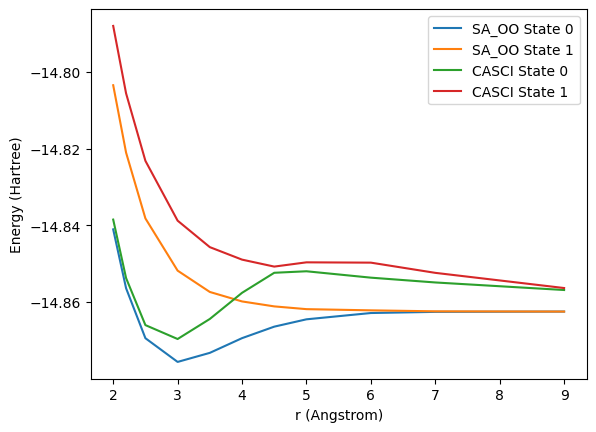

In [20]:
import matplotlib.pyplot as plt

sa_oo_eners=np.array(sa_oo_eners)
casci_eners= np.array(casci_eners)

fig, ax = plt.subplots()
ax.plot(xvals, sa_oo_eners[:, 0], label="SA_OO State 0")
ax.plot(xvals, sa_oo_eners[:, 1], label="SA_OO State 1")
ax.plot(xvals, casci_eners[:, 0], label="CASCI State 0")
ax.plot(xvals, casci_eners[:, 1], label="CASCI State 1")
ax.set_xlabel('r (Angstrom)')
ax.set_ylabel('Energy (Hartree)')
ax.legend()

## 3. Hamiltonian Simulation algorithms <a class="anchor" id="3"></a>

We now illustrate a few other approches based on time-evolution of the Hamiltonian. Although these algorithms are not NISQ-friendly, they do not require non-linear optimization of parameters like the variational methods encountered in the previous sections. They may be a better choice for future fault-tolerant architectures.

### 3.1 Multi-Reference Selected Quantum Krylov (MRSQK) <a class="anchor" id="31"></a>

The multi-reference selected Quantum Krylov algorithm as outlined in [arXiv:1911.05163](https://arxiv.org/abs/1911.05163) uses multiple reference states and performs multiple time evolutions $U = e^{-iH\tau}$ for time $\tau$, to generate a Krylov representation of the system. The method relies on building two matrices ${\cal{H}}$ and $S$, whose elements are defined by ${\cal{H}_{ia,jb}} = \left<\phi_a\right|U^i H U^j\left|\phi_b\right>$ and $S_{ia,jb} = \left<\phi_a\right|U^i U^j\left|\phi_b\right>$, where $\phi_a, \phi_b$ denote different reference configurations. The matrix elements are measured using the procedure outlined in [arXiv:1911.05163](https://arxiv.org/abs/1911.05163) and the energies obtained through solving ${\cal{H}}V = SVE$.

In [arXiv:2109.06868](https://arxiv.org/abs/2109.06868), it was further noticed that one can use any function of $\cal{H}$ to obtain the eigenvalues. For example, one could use $f({\cal{H}})=e^{-iH\tau}=U$. The same procedure results in the matrix elements $f({\cal{H}})_{ia,jb} = \left<\phi_a\right|U^i U U^j\left|\phi_b\right>, S_{ia,jb} = \left<\phi_a\right|U^i U^j\left|\phi_b\right>$ for the eigenvalue problem $f({\cal{H}})V=SVf(E)$. As $E$ is a diagonal matrix, the correct energies can be obtained by calculating the phase of the eigenvalues ($f(E)=e^{-iE\tau}$) and dividing by $\tau$. (i.e. $\arctan \left[\Im(f(E))/\Re(f(E)) \right]/\tau$). The resulting circuit is slightly longer but much fewer measurements are required. It is worth mentioning that [qubitization](https://arxiv.org/abs/1610.06546), which natively implements $e^{i \arccos(H\tau)}$, can be used without issue. Qubitization is currently one of the most efficient algorithms that implements time-evolution.

In [21]:
from itertools import product
from scipy.linalg import eigh, eigvals

from tangelo.linq import get_backend, Circuit, Gate
from tangelo.toolboxes.operators import QubitOperator, count_qubits
from tangelo.toolboxes.qubit_mappings.statevector_mapping import vector_to_circuit
from tangelo.toolboxes.ansatz_generator.ansatz_utils import controlled_pauliwords, trotterize

In [22]:
# Number of Krylov vectors
n_krylov = 4
# Simulation time for each unitary
tau = 0.04
# Qubit Mapping
mapping = "jw"

backend = get_backend()

# Qubit operator for Li2
qu_op =  f2q_mapping(mol_Li2.fermionic_hamiltonian, mapping, mol_Li2.n_active_sos,
                     mol_Li2.n_active_electrons, up_then_down=False, spin=mol_Li2.spin)

# control qubit
c_q = count_qubits(qu_op)

# Operator that measures off-diagonal matrix elements i.e. 2|0><1|
zeroone = (QubitOperator(f"X{c_q}", 1) + QubitOperator(f"Y{c_q}", 1j))

# Controlled unitaries for each term in qu_op
c_qu = controlled_pauliwords(qubit_op=qu_op, control=c_q, n_qubits=5)

# Controlled time-evolution of qu_op
c_trott = trotterize(qu_op, time=tau, n_trotter_steps=1, trotter_order=1, control=4)

# Generate multiple controlled-reference states.
reference_states = list()
reference_vecs = [[1, 1, 0, 0], [1, 0, 0, 1]]
for vec in reference_vecs:
    circ = vector_to_circuit(vec)
    gates = [Gate("C"+gate.name, target=gate.target, control=4) for gate in circ]
    reference_states += [Circuit(gates)]

# Calculate MRSQK
sab = np.zeros((n_krylov, n_krylov), dtype=complex)
hab = np.zeros((n_krylov, n_krylov), dtype=complex)
fhab = np.zeros((n_krylov, n_krylov), dtype=complex)

for a, b in product(range(n_krylov), range(n_krylov)):
    # Generate Ua and Ub unitaries
    ua = reference_states[a%2] + c_trott * (a//2) if a > 1 else reference_states[a%2]
    ub = reference_states[b%2] + c_trott * (b//2) if b > 1 else reference_states[b%2]
    
    # Build circuit from Figure 2 for off-diagonal overlap
    hab_circuit = Circuit([Gate("H", c_q)]) + ua + Circuit([Gate("X", c_q)]) + ub
    sab[a, b] = backend.get_expectation_value(zeroone, hab_circuit) / 2
    sab[b, a] = sab[a, b].conj()

    # Hamiltonian matrix element for f(H) = e^{-i H \tau}
    fhab[a, b] = backend.get_expectation_value(zeroone, hab_circuit+c_trott.inverse())/2

    # Return statevector for faster calculation of Hamiltonian matrix elements
    _ , initial_state = backend.simulate(hab_circuit, return_statevector=True)
    for i, (term, coeff) in enumerate(qu_op.terms.items()):

        # From calculated statevector append controlled-pauliword for each term in Hamiltonian and measure zeroone
        expect = coeff*backend.get_expectation_value(zeroone, c_qu[i], initial_statevector=initial_state) / 2

        # Add term to sum
        hab[a, b] += expect

e, v = eigh(hab, sab)
print(f"The HV=SVE energies are {e}")
e = eigvals(fhab, sab)
print(f"The f(H)V=SVf(E) energies are {np.arctan2(np.imag(e), np.real(e))/tau}")

algorithm_resources["mrsqk"] = dict()
algorithm_resources["mrsqk"]["qubit_hamiltonian_terms"] = 0
algorithm_resources["mrsqk"]["circuit_2qubit_gates"] = hab_circuit.counts.get("CNOT", 0)
algorithm_resources["mrsqk"]["n_post_terms"] = n_krylov**2

The HV=SVE energies are [-14.8696203  -14.83876634 -14.78403833 -14.680196  ]
The f(H)V=SVf(E) energies are [-14.86962029 -14.680196   -14.83876634 -14.78403833]


The calculated energies are very close to the exact energies calculated at the top of the notebook.

### 3.2 Rodeo Algorithm <a class="anchor" id="32"></a>

Another method based on Hamiltonian simulation that can be used to obtain energies is the Rodeo Algorithm. This simulates the Hamiltonian for many random lengths of time with different input energies. The probability of the ancilla qubit being 0 for a given energy $E$ is $P_0(E) = \frac{1 + e^{-\sigma^2 (E_i - E)^2/2}}{2}$ where $E_i$ is one of the eigenvalues of the Hamiltonian. The algorithm is outlined in [arXiv:2110.07747](https://arxiv.org/abs/2110.07747). When the energy $E$ is close to an eigenvalue $E_i$, the probability is maximized. Therefore, one would observe peaks in success probability when the input energy $E$ is an eigenvalue. 

The cell illustrates this process over 10 iterations for each energy, for simplicity. We however show a plot resulting from 1,000 iterations afterwards. To reduce the computational complexity, we also use the [symmetry-conserving Bravyi-Kitaev](https://arXiv.org/abs/1701.08213) mapping to reduce the number of qubits to 2 by remove qubits corresponding to spin and electron number. This means we can only obtain the singlet state energies. A separate calculation would be needed to calculate the triplet energy.

In [23]:
# One rodeo cycle as defined in Fig.1 of arXiv.2110.07747
def rodeo_cycle(hobj, energy, t, i):
    circuit = Circuit([Gate("H", i)])
    circuit += trotterize(hobj, time=t, control=i, trotter_order=2, n_trotter_steps=40)
    circuit += Circuit([Gate("PHASE", i, parameter=energy*t), Gate("H", i)])
    return circuit

In [24]:
from tangelo.toolboxes.qubit_mappings.statevector_mapping import do_scbk_transform

h_obj =  f2q_mapping(mol_Li2.fermionic_hamiltonian, "scbk", mol_Li2.n_active_sos,
                     mol_Li2.n_active_electrons, up_then_down=True, spin=mol_Li2.spin)

n_qubits = count_qubits(h_obj)

# Stretch factor of 300 to make eigenvalue gap larger. Therefore, time evolution needs to be shorter.
h_obj = 300*(h_obj - QubitOperator((), -14.85))

sim = get_backend()

sigma = 0.4

# We will use multiple reference states as probability depends on overlap with starting state.
ref_states = [vector_to_circuit(do_scbk_transform([1, 1, 0, 0], 4)),
              vector_to_circuit(do_scbk_transform([1, 0, 1, 0], 4)),
              vector_to_circuit(do_scbk_transform([0, 0, 1, 1], 4))]

# Equivalent to energies from -14.9 -> 14.75 for 10 iterations.
energies = [-0.05*300 +300*0.005*i for i in range(30)]
success_prob = list()
for energy in energies:
    success=0
    for sample in range(10):
        t = np.random.normal(0, sigma, 1)
        circuit = np.random.choice(ref_states)
        for i, tk in enumerate(t):
            circuit += rodeo_cycle(h_obj, energy, tk, i+n_qubits)
        f, _ = sim.simulate(circuit)
        for key, v in f.items():
            if key[2:] == "0":
                success += v
    success_prob.append(success/10)

algorithm_resources["rodeo"] = dict()
algorithm_resources["rodeo"]["qubit_hamiltonian_terms"] = 0
algorithm_resources["rodeo"]["circuit_2qubit_gates"] = circuit.counts.get("CNOT", 0)
algorithm_resources["rodeo"]["n_post_terms"] = 30

Text(0, 0.5, 'Success Probability')

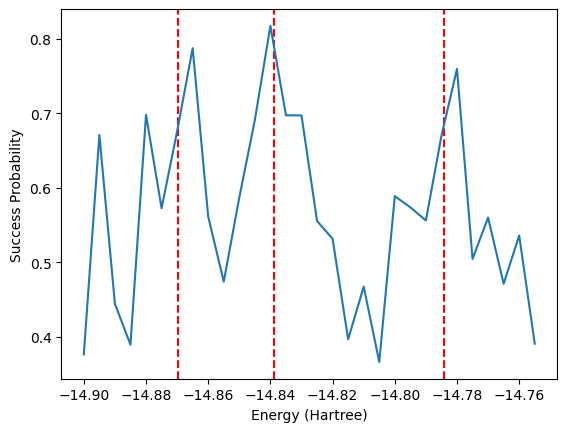

In [25]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('w')
ax.set_facecolor('w')
evals = [-14.8696203,  -14.83876635, -14.78403833]
for e in evals:
    ax.axvline(x=e, color='r',ls='--')
ax.plot(np.array(energies)/300-14.85, success_prob)
ax.set_xlabel('Energy (Hartree)')
ax.set_ylabel('Success Probability')

The above plot shows promise that the correct energies indeed align with peaks in the success probability, despite our small number of iterations. To save time, below is the result after running the above code for 1000 iterations. The peaks are centered on the exact energies, represented by the vertical red dashed lines.

<a class="anchor" id="rodeo"></a>
<img align="left" width="400" src="img/rodeo_1000.png" />

## 4. Closing words <a class="anchor" id="4"></a>

We have shown a few of the many different algorithms that can be used to calculate excited states using Tangelo. Unlike ground states, the use of variational methods requires either penalizing against previously calculated states or the optimization of a collection of orthogonal states. Outside of variational methods, we have shown a few Hamiltonian simulation based algorithms to calculate excited states. 

But quantum resource requirements are an important aspect of quantum algorithm design: let's have a look at the resources required for each algorithm we tried on our use case. In particular, the following metrics:

- `# measurements basis` is the number of distinct measurements for each function evaluation in the variational optimization process.
- `# CNOT gates` is the number of CNOT gates in each circuit.
- `# post measurements basis` is the number of measurements needed to successfully post-process the output of the algorithm. 

We note that `# CNOT gates` for each variational algorithm could be improved greatly if an algorithm such as ADAPT-VQE was used to create an ansatz. Similarly, `# CNOT gates` could be reduced for the time-evolution algorithms with more advanced approaches such as qubitization.

In [26]:
format = "{:<40} {:<20} {:<20} {:<20}"
print(format.format("Algorithm", "# measurements", "# CNOT gates", "# post measurements"))
for method, resources in algorithm_resources.items():
  print(format.format(method, resources["qubit_hamiltonian_terms"], resources["circuit_2qubit_gates"], resources.get("n_post_terms", 0)))

Algorithm                                # measurements       # CNOT gates         # post measurements 
vqe_ground_state                         15                   64                   0                   
vqe_triplet_state                        15                   128                  0                   
vqe_deflation_state_1                    16                   192                  0                   
vqe_deflation_state_2                    17                   192                  0                   
vqe_deflation_state_3                    18                   192                  0                   
quantum_subspace_expansion               18                   192                  288                 
sa_vqe                                   60                   128                  0                   
mc_vqe                                   60                   128                  540                 
sa_vqe_deflation                         18                   19

These are the resource requirements that came out from calculations on our small Li$_2$ use case in minimal basis set, featuring two  2 electrons in 2 orbitals.

But what of BODIPY ?

In [27]:
bodipy = SQMol("data/bodipy.xyz", q=0, spin=0, basis="sto-3g")
print(f"Active electrons = {bodipy.n_active_mos}")
print(f"Active orbitals = {bodipy.n_active_electrons}")

Active electrons = 63
Active orbitals = 70


Whereas we did calculations with 2 electrons in 2 orbitals, the full calculation of BODIPY in the minimal STO-3G basis would entail 63 electrons in 70 orbitals, with the core electrons frozen. The number of qubits needed to represent this would be 140 for the Jordan-Wigner mapping, compared to the 4 (+1 ansatz for the Hamiltonian simulation algorithms) qubits used in this notebook. [J. Chem. Theory. Comput. 2015, 11, 6](https://pubs.acs.org/doi/10.1021/ct500775r) showed reasonable results using CASSCF with 12 electrons in 11 orbitals, which would be a 22-qubit problem using the Jordan-Wigner mapping. Another issue is the number of CNOT gates, which would be much larger for the full 22-qubit problem than shown in the table for our use case. 

This system is orders or magnitude harder, and emphasize how it is crucial that we design and choose approaches that require as little quantum computational resources as possible to make such use cases tractable in the future.

There is still much work to be done to efficiently calculate excited states using quantum computers, and allow us to tackle more industrially-relevant use cases.

What will you do with Tangelo? 